# SYDE556/750 Assignment 2: Spiking Neurons

### Peter Duggins
### February 22, 2016

## 1) Generating a random input signal

### 1.1) Gaussian white noise

Create a function called that generates a randomly varying $x(t)$ signal chosen from a white noise distribution.  Call it 'generate_signal' and ensure that it returns $x(t)$ and $X(\omega)$. The inputs to the function are:

- ``T``: the length of the signal in seconds
- ``dt``: the time step in seconds
- ``rms``: the root mean square power level of the signal.  That is, the resulting signal should have $\sqrt{{1 \over T} \int{x(t)^2}dt}=rms$
- ``limit``: the maximum frequency for the signal (in Hz)
- ``seed``: the random number seed to use (so we can regenerate the same signal again)

- $\Delta \omega$ will be $2 \pi / T$
- To keep the signal real, $X(\omega)=X(-\omega)^*$ (the complex conjugate: the real parts are equal, and the imaginary parts switch sign)
- When randomly generating $X(\omega)$ values, sample them from a Normal distribution $N(\mu=0,\sigma=1)$.  Remember that these are complex numbers, so sample twice from the distribution; once for the real component and once for the imaginary.
- To implement the ``limit``, set all $X(\omega)$ components with frequencies above the limit to 0
- To implement the ``rms``, generate the signal, compute its RMS power ($\sqrt{{1 \over T} \int{x(t)^2}dt}=rms$) and rescale so it has the desired power.

These are the helper functions needed I wrote for the assignment. Evaluate these cells first.

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

class spikingLIFneuron():

    def __init__(self,x1_dot_e,x2_dot_e,a1,a2,encoder,tau_ref,tau_rc):
        self.x1_dot_e=float(x1_dot_e)
        self.x2_dot_e=float(x2_dot_e)
        self.a1=float(a1)
        self.a2=float(a2)
        self.e=encoder
        self.tau_ref=tau_ref
        self.tau_rc=tau_rc
        self.Jbias=0.0
        self.alpha=0.0
        self.V=0.0
        self.dVdt=0.0
        self.stimulus=[]
        self.spikes=[]
        self.Vhistory=[]

        if self.x1_dot_e==0:
            self.Jbias=1/(1-np.exp((self.tau_ref - 1/self.a1)/self.tau_rc))
            self.alpha=(1/self.x2_dot_e) * (1/(1-np.exp((self.tau_ref - 1/self.a2)/self.tau_rc)) - self.Jbias)
        elif self.x2_dot_e==0:
            self.Jbias=1/(1-np.exp((self.tau_ref - 1/self.a2)/self.tau_rc))
            self.alpha=(1/self.x1_dot_e) * (1/(1-np.exp((self.tau_ref - 1/self.a1)/self.tau_rc)) - self.Jbias)
        else:
            self.Jbias=(1/(1-self.x2_dot_e/self.x1_dot_e)) - 1/(1-np.exp((self.tau_ref - 1/self.a2)/self.tau_rc)) - \
              (self.x2_dot_e/self.x1_dot_e) * 1/(1-np.exp((self.tau_ref - 1/self.a1)/self.tau_rc))
            self.alpha=(1/self.x2_dot_e) * (1/(1-np.exp((self.tau_ref - 1/self.a2)/self.tau_rc)) - self.Jbias)

    def set_spikes(self,stimulus,T,dt):
        self.stimulus=stimulus #an array
        self.spikes=[]
        self.Vhistory=[]
        ref_window=int(self.tau_ref/dt)

        for t in range(len(stimulus)):
            self.J=self.alpha*np.dot(self.stimulus[t],self.e) + self.Jbias
            self.dVdt=((1/self.tau_rc)*(self.J-self.V))
            for h in range(ref_window):    #check if there have been spikes in the last t_rc seconds
                if len(self.spikes) >= ref_window and self.spikes[-(h+1)] == 1:
                    self.dVdt=0     #if so, voltage isn't allowed to change
            self.V=self.V+dt*self.dVdt  #Euler's Method Approximation V(t+1) = V(t) + dt *dV(t)/dt
            if self.V >= 1.0:
                self.spikes.append(1)   #a spike
                self.V=0.0    #reset
            else:
                self.spikes.append(0)   #not a spike
                if self.V < 0.0: self.V=0.0
            self.Vhistory.append(self.V)

    def get_spikes(self):
        return self.spikes

def get_decoders_smoothed(spikes,h,x):

    S=len(x)
    #have to truncate from 'full' here, mode='same' messes up last half of list
    A_T=np.array([np.convolve(s,h,mode='full')[:len(spikes[0])] for s in spikes]) 
    A=np.matrix(A_T).T
    x=np.matrix(x).T
    upsilon=A_T*x/S
    gamma=A_T*A/S
    d=np.linalg.pinv(gamma)*upsilon
    return d

def get_estimate_smoothed(spikes,h,d):

    xhat=np.sum([d[i]*np.convolve(spikes[i],h,mode='full')[:len(spikes[i])] for i in range(len(d))],axis=0)
    xhat=xhat.T
    return xhat

def generate_signal(T,dt,rms,limit,seed,distribution='uniform'):

    #first generate x_w, with the specified constraints, then use an inverse fft to get x_t
    rng=np.random.RandomState(seed=seed)
    t=np.arange(int(T/dt))*dt
    delta_w = 2*np.pi/T #omega stepsize
    w_vals = np.arange(-len(t)/2,0,delta_w) #make half of X(w), those with negative freq
    w_limit=2*np.pi*limit #frequency in radians
    bandwidth=2*np.pi*limit #bandwidth in radians
    # bandwidth=limit
    x_w_half1=[]
    x_w_half2=[]

    for i in range(len(w_vals)):
        if distribution=='uniform':
            if abs(w_vals[i]) < w_limit:
                x_w_i_real = rng.normal(loc=0,scale=1)
                x_w_i_im = rng.normal(loc=0,scale=1)
                x_w_half1.append(x_w_i_real + 1j*x_w_i_im)
                x_w_half2.append(x_w_i_real - 1j*x_w_i_im)  

        elif distribution=='gaussian':          
            sigma=np.exp(-np.square(w_vals[i])/(2*np.square(bandwidth)))
            if sigma > np.finfo(float).eps: #distinguishable from zero
                x_w_i_real = rng.normal(loc=0,scale=sigma)
                x_w_i_im = rng.normal(loc=0,scale=sigma)  
                x_w_half1.append(x_w_i_real + 1j*x_w_i_im)
                x_w_half2.append(x_w_i_real - 1j*x_w_i_im) #make the 2nd half of X(w) with complex conjugates 

    x_w_pos=np.hstack((x_w_half2[::-1],np.zeros(len(t)/2-len(x_w_half2))))
    x_w_neg=np.hstack((np.zeros(len(t)/2-len(x_w_half1)),x_w_half1))
    x_w=np.hstack(([0+0j],x_w_pos,x_w_neg)) #amplitudes corresponding to [w_0, w_pos increasing, w_neg increasing]
    x_t=np.fft.ifft(x_w)
    true_rms=np.sqrt(dt/T*np.sum(np.square(x_t)))   #normalize time and frequency signals using RMS
    x_t = x_t*rms/true_rms
    x_w = x_w*rms/true_rms

    return x_t.real, x_w     #return real part of signal to avoid warning, but I prmose they are less than e-15


Populating the interactive namespace from numpy and matplotlib


#### 1.1a Plot $x(t)$ for three randomly generated signals with ``limit`` at 5, 10, and 20Hz.  For each of these, ``T``=1, ``dt``=0.001, and ``rms``=0.5.

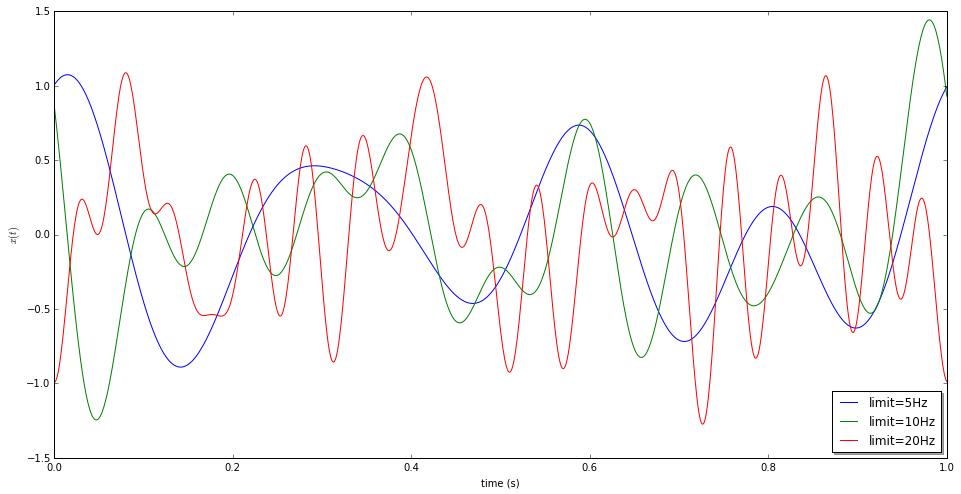

In [2]:
def one_pt_one_a():

    T=1
    dt=0.001
    rms=0.5
    limit=10
    seed=1
    t=np.arange(int(T/dt)+1)*dt

    limits=[5,10,20]
    x_t_list=[]
    for i in range(len(limits)):  
        seed=i
        limit=limits[i]
        x_ti, x_wi = generate_signal(T,dt,rms,limit,seed,'uniform')
        x_t_list.append(x_ti)

    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    for i in range(len(limits)):  
        ax.plot(t,x_t_list[i],label='limit=%sHz' %(limits[i]))
        # ax.plot(t,x_t_list[i],label='limit=%s*2$\pi$ radians' %(limits[i]))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('$x(t)$')
    legend=ax.legend(loc='best',shadow=True)
    plt.show()

one_pt_one_a()

#### 1.1b Plot the average $|X(\omega)|$ (the norm of the Fourier coefficients) over 100 signals generated with  ``T``=1, ``dt``=0.001, ``rms``=0.5, and ``limit``=10 (each of these 100 signals should have a different ``seed``).  The plot should have the x-axis labeled ($\omega$ in radians) and the average $|X|$ value for that $\omega$ on the y-axis.

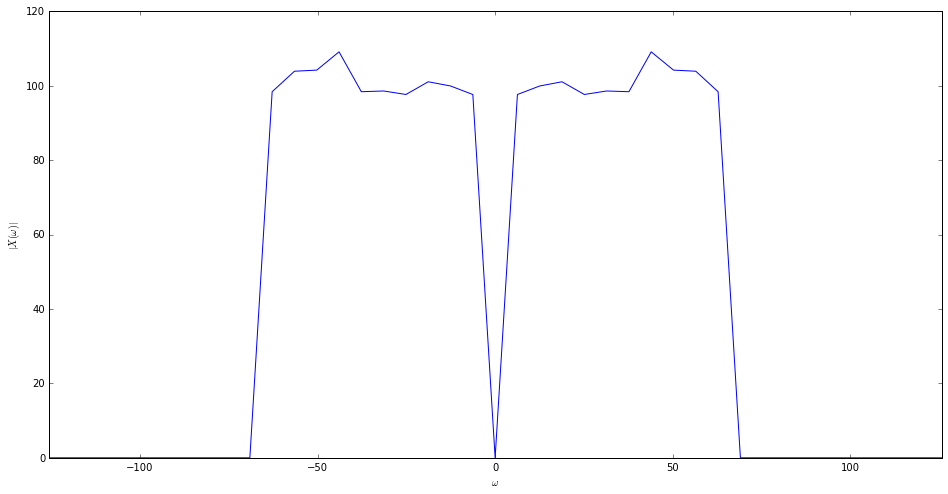

In [3]:
def one_pt_one_b():

    T=1
    dt=0.001
    rms=0.5
    limit=10
    avgs=100

    x_w_list=[]
    for i in range(avgs):
        seed=i
        x_ti, x_wi = generate_signal(T,dt,rms,limit,seed,'uniform')
        x_w_list.append(np.abs(x_wi))
    x_w_avg=np.average(x_w_list,axis=0)
    w_vals=np.fft.fftfreq(len(x_w_avg))*2*np.pi/dt
    w_limit=2*np.pi*limit

    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.plot(np.sort(w_vals),np.fft.fftshift(x_w_avg))
    ax.set_xlabel('$\omega$')
    ax.set_ylabel('$|X(\omega)|$')
    ax.set_xlim(-w_limit*2, w_limit*2)
    plt.show()
    
one_pt_one_b()

### 1.2) Gaussian power spectrum noise

Create a modified version of your function from question 1.1 that produces noise with a different power spectrum.  Instead of having the $X(\omega)$ values be 0 outside of some limit and sampled from $N(\mu=0,\sigma=1)$ inside that limit, we want a smooth drop-off of power as the frequency increases.  In particular, instead of the ``limit``, we sample from $N(\mu=0,\sigma=e^{-{\omega^2/(2*b^2)}})$ where $b$ is the new ``bandwidth`` parameter that replaces the ``limit`` parameter.

#### 1.2a Plot $x(t)$ for three randomly generated signals with ``bandwidth`` at 5, 10, and 20Hz.  For each of these, ``T``=1, ``dt``=0.001, and ``rms``=0.5.

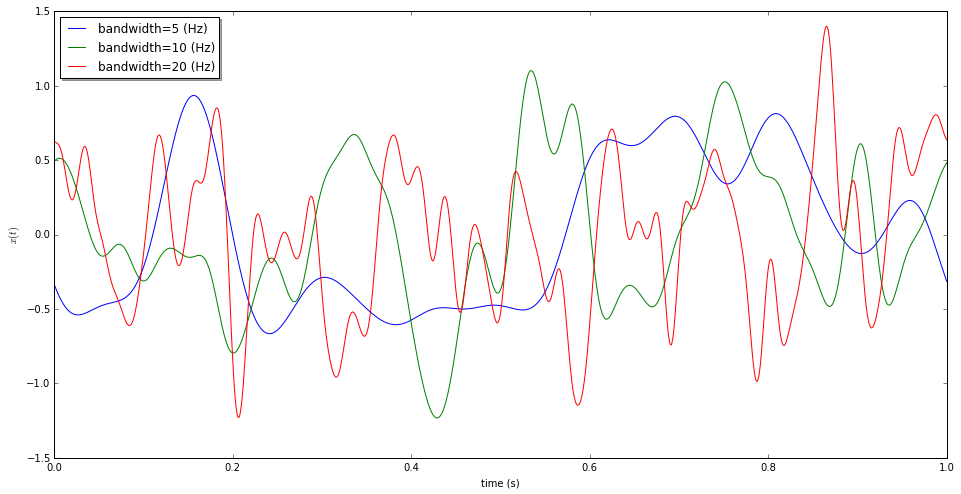

In [4]:
def one_pt_two_a():

    T=1
    dt=0.001
    rms=0.5
    seed=1
    t=np.arange(int(T/dt)+1)*dt

    bandwidths=[5,10,20]
    x_t_list=[]
    for i in range(len(bandwidths)):  
        seed=i
        bandwidth=bandwidths[i]
        x_ti, x_wi = generate_signal(T,dt,rms,bandwidth,seed,'gaussian')
        x_t_list.append(x_ti)

    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    for i in range(len(bandwidths)):  
        # ax.plot(t,x_t_list[i],label='bandwidths*2$\pi$ radians' %(bandwidths[i]))
        ax.plot(t,x_t_list[i],label='bandwidth=%s (Hz)' %(bandwidths[i]))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('$x(t)$')
    legend=ax.legend(loc='best',shadow=True)
    plt.show()

one_pt_two_a()

#### 1.2b Plot the average $|X(\omega)|$ (the norm of the Fourier coefficients) over 100 signals generated with  ``T``=1, ``dt``=0.001, ``rms``=0.5, and ``bandwidth``=10 (each of these 100 signals should have a different ``seed``)

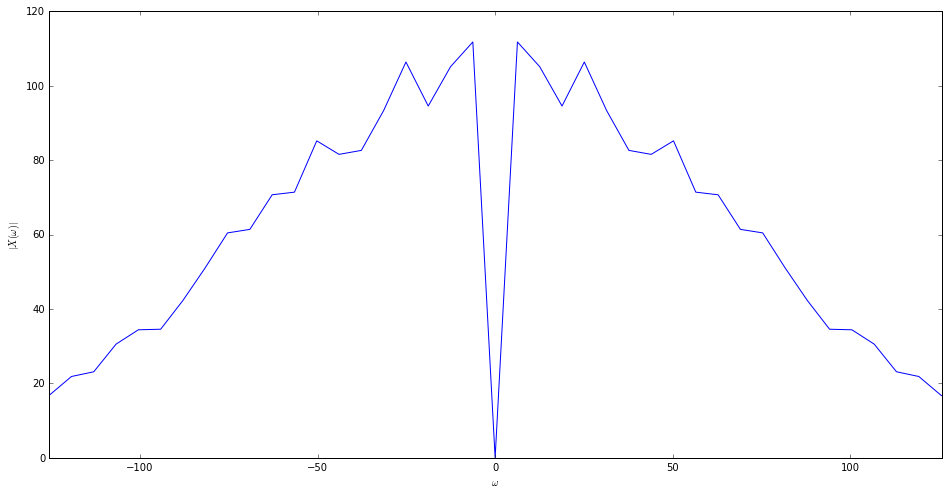

In [5]:
def one_pt_two_b():

    T=1
    dt=0.001
    rms=0.5
    bandwidth=10
    avgs=100

    x_w_list=[]
    for i in range(avgs):
        seed=i
        x_ti, x_wi = generate_signal(T,dt,rms,bandwidth,seed,'gaussian')
        x_w_list.append(np.abs(x_wi))
    x_w_avg=np.average(x_w_list,axis=0)
    w_vals=np.fft.fftfreq(len(x_w_avg))*2*np.pi/dt
    w_limit=2*np.pi*bandwidth

    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.plot(np.sort(w_vals),np.fft.fftshift(x_w_avg))
    ax.set_xlabel('$\omega$')
    ax.set_ylabel('$|X(\omega)|$')
    ax.set_xlim(-w_limit*2, w_limit*2)
    plt.show()
    
one_pt_two_b()

## 2) Simulating a Spiking Neuron

Write a program to simulate a single Leaky-Integrate and Fire neuron.  The core equation is $ {{dV} \over {dt}} = {1 \over {\tau_{RC}}} (J - V)$ (to simplify life, this is normalized so that $R$=1, the resting voltage is 0 and the firing voltage is 1).  This equation can be simulated numerically by taking  small time steps (Euler's method).  When the voltage reaches the threshold $1$, the neuron will spike and then reset its voltage to $0$ for the next $\tau_{ref}$ amount of time.  Also, if the voltage goes below zero at any time, reset it back to zero.  For this question, $\tau_{RC}$=0.02 and $\tau_{ref}$=0.002 Since we want to do inputs in terms of $x$, we need to do $J = \alpha e \cdot x + J^{bias}$.  For this neuron, set $e$ to $+1$ and find $\alpha$ and $J^{bias}$ such that the firing rate when $x=0$ is 40Hz and when $x=1$ it is 150Hz.  To find these $\alpha$ and $J^{bias}$ values, use the approximation for the LIF neuron $a(J)={1 \over {\tau_{ref}-\tau_{RC}ln(1-{1 \over J})}}$.

#### 2a Plot the spike output for a constant input of $x=0$ over 1 second.  Report the number of spikes.  Do the same thing for $x=1$.  Use ``dt``=0.001 for the simulation.

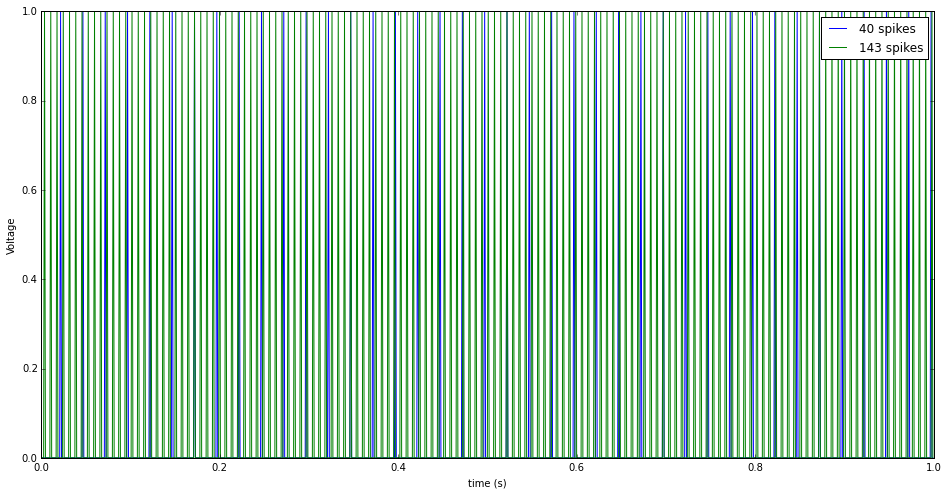

In [6]:
def two_a():

    x1=0
    x2=1
    a1=40
    a2=150
    encoder=1
    tau_ref=0.002
    tau_rc=0.02
    T=1.0
    dt=0.001

    n1=spikingLIFneuron(x1,x2,a1,a2,encoder,tau_ref,tau_rc)
    stimulus1 = np.linspace(0.0,0.0,T/dt)  #constant stimulus of zero in an array
    n1.set_spikes(stimulus1,T,dt)
    spikes1=n1.get_spikes()
    stimulus2 = np.linspace(1.0,1.0,T/dt)  #constant stimulus of one
    n1.set_spikes(stimulus2,T,dt)
    spikes2=n1.get_spikes()

    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    times=np.arange(0,T,dt)
    ax.plot(times,spikes1, 'b', label='%s spikes' %np.count_nonzero(spikes1))
    ax.plot(times,spikes2, 'g', label='%s spikes' %np.count_nonzero(spikes2))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Voltage')
    # ax.set_xlim(0,T)
    # ax.set_ylim(0,2)
    legend=ax.legend(loc='best') 
    plt.show()
    
two_a()

#### 2b Does the observed number of spikes in the previous part match the expected number of spikes for $x=0$ and $x=1$?  Why or why not?  What aspects of the simulation would affect this accuracy?

The number of spikes we expect at $stimulus=0$ is $40Hz$, because this is the firing rate corresponding to $x(t)=0$ (no external stimulus) that we originally specified. When $stimulus = 1$, we expect the firing rate corresponding to $x(t)=1$, which is $143Hz$ when we specified a rate of $150hz$. Decreasing the timestep $dt$ improves this accuracy (goes to $149$ with $dt=0.0001$), because Euler's method becomes more exact and because the refractory period is specified with more precision.

#### 2c Plot the spike output for $x(t)$ generated using your function from part 1.1.  Use ``T``=1, ``dt``=0.001, ``rms``=0.5, and ``limit``=30.  Overlay on this plot $x(t)$.

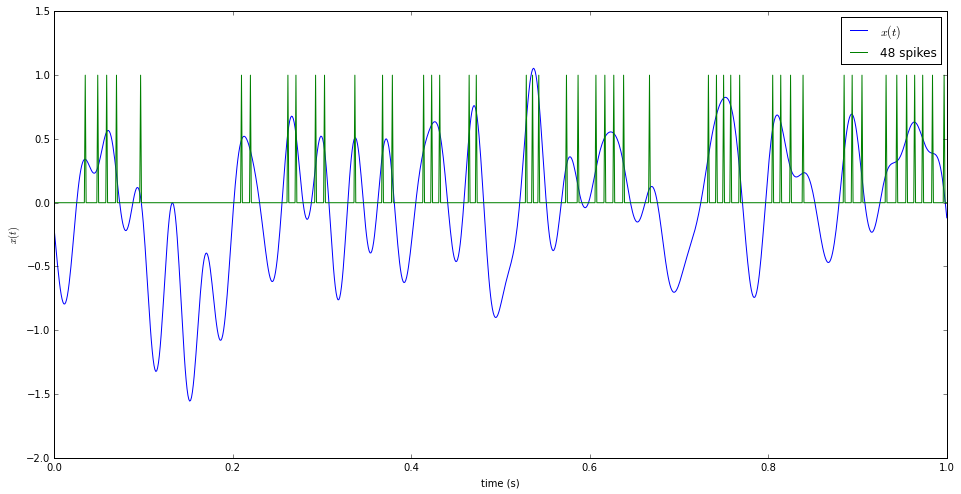

In [7]:
def two_c():

    rms=0.5
    limit=30
    seed=3
    x1=0
    x2=1
    a1=40
    a2=150
    encoder=1
    tau_ref=0.002
    tau_rc=0.02
    T=1.0
    dt=0.001

    n1=spikingLIFneuron(x1,x2,a1,a2,encoder,tau_ref,tau_rc)
    t=np.arange(int(T/dt)+1)*dt
    x_t, x_w = generate_signal(T,dt,rms,limit,seed,'uniform')
    stimulus3 = np.array(x_t)
    n1.set_spikes(stimulus3,T,dt)
    spikes3=n1.get_spikes()

    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    times=np.arange(0,T,dt)
    ax.plot(t,x_t, label='$x(t)$')
    ax.plot(t,spikes3, label='%s spikes' %np.count_nonzero(spikes3))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('$x(t)$')
    # ax.set_xlim(0,T)
    # ax.set_ylim(0,2)
    legend=ax.legend(loc='best') 
    plt.show()

two_c()

#### 2d Using the same $x(t)$ signal as in part (c), plot the neuron's voltage over time for the first 0.2 seconds, along with the spikes over the same time.

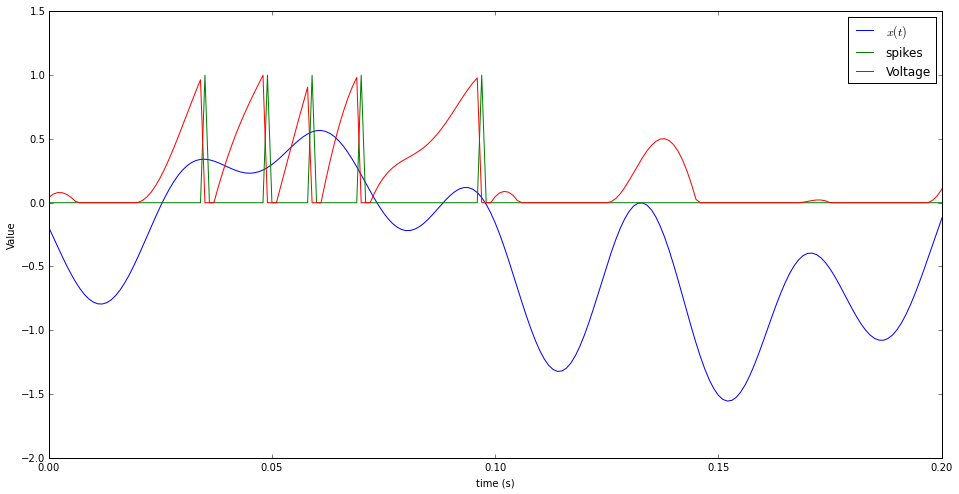

In [8]:
def two_d():

    rms=0.5
    limit=30
    seed=3
    x1=0
    x2=1
    a1=40
    a2=150
    encoder=1
    tau_ref=0.002
    tau_rc=0.02
    T=1.0
    dt=0.001

    n1=spikingLIFneuron(x1,x2,a1,a2,encoder,tau_ref,tau_rc)
    t=np.arange(int(T/dt)+1)*dt
    x_t, x_w = generate_signal(T,dt,rms,limit,seed,'uniform')
    stimulus3 = np.array(x_t)
    n1.set_spikes(stimulus3,T,dt)
    spikes3=n1.get_spikes()

    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    times=np.arange(0,T,dt)
    ax.plot(t,x_t, label='$x(t)$')
    ax.plot(t,spikes3, label='spikes')
    ax.plot(t,n1.Vhistory, label='Voltage')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Value')
    ax.set_xlim(0,0.2)
    # ax.set_ylim(0,2)
    legend=ax.legend(loc='best') 
    plt.show()
    
two_d()

#### 2.BONUS: How could you improve this simulation (in terms of how closely the model matches actual equation) without significantly increasing the computation time?  0.5 marks for having a good idea, and up to 1 marks for actually implementing it and showing that it works.

First, you could increase the accuracy of the spike timing by implementing a better ODE solver for voltage in the LIF equation. Rather than using Euler's method to calculate $V(t)$ based on the first order approximation $dV/dt$, you could use a dedicated solved like 4th/5th order Runge-Kutta, which is the standard for libraries like scipy.integrate. Similarly, you could implement an adaptive stepsize, to capture rapid changes in $x(t)$ without making $dt$ smaller for the entire $T$ and significantly increases computation time.

Second, you could use SVD to calculate the direction(s) of greatest variation within $x(t)$, then set the encoders along this direction (preferably at least  one positive and negative). This would ensure that the spike rate of this neuron is highly correlated with changes in the signal, though it wouldn't have much effect in the 1D case. 

Third, you could use a different basis function for the neuron tuning curves which better matched the statistics of the signal. Because this signal is derived from a fourier transformation, you could use a basis of complex exponentials with different natural frequencies and amplitudes.

## 3) Simulating Two Spiking Neurons

Write a program that simulates two neurons.  The two neurons have exactly the same parameters, except for one of them $e=1$ and for the other $e=-1$.  Other than that, use exactly the same settings as in question 2.

#### 3a Plot $x(t)$ and the spiking output for $x(t)=0$ (both neurons should spike at ~40 spikes per second)

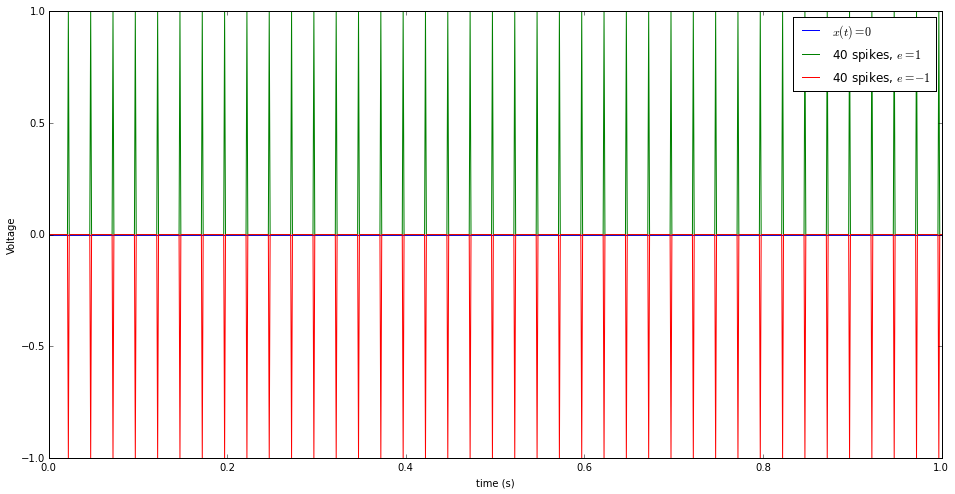

In [9]:
def three_a():

    x1=0
    x2=1
    a1=40
    a2=150
    e1=1
    e2=-1
    tau_ref=0.002
    tau_rc=0.02
    T=1
    dt=0.001
    rms=0.5
    limit=30
    seed=3

    x1_dot_e1=np.dot(x1,e1)
    x2_dot_e1=np.dot(x2,e1)
    x1_dot_e2=np.dot(x1,e2)
    x2_dot_e2=np.dot(-x2,e2)
    n1=spikingLIFneuron(x1_dot_e1,x2_dot_e1,a1,a2,e1,tau_ref,tau_rc)
    n2=spikingLIFneuron(x1_dot_e2,x2_dot_e2,a1,a2,e2,tau_ref,tau_rc)
    t=np.arange(int(T/dt)+1)*dt
    stimulus1 = np.linspace(0,0,T/dt+1)  #constant stimulus of zero in an array
    n1.set_spikes(stimulus1,T,dt)
    n2.set_spikes(stimulus1,T,dt)
    spikes1=n1.get_spikes()
    spikes2=n2.get_spikes()

    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.plot(t,stimulus1, label='$x(t)=0$')
    ax.plot(t,spikes1, label='%s spikes, $e=1$' %np.count_nonzero(spikes1))
    ax.plot(t,-np.array(spikes2), label='%s spikes, $e=-1$' %np.count_nonzero(spikes2))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Voltage')
    ax.set_xlim(0,T)
    # ax.set_ylim(0,2)
    legend=ax.legend(loc='best') 
    plt.show()
    
three_a()

#### 3b Plot $x(t)$ and the spiking output for $x(t)=1$ (one neuron should spike at ~150 spikes per second, and the other should not spike at all)

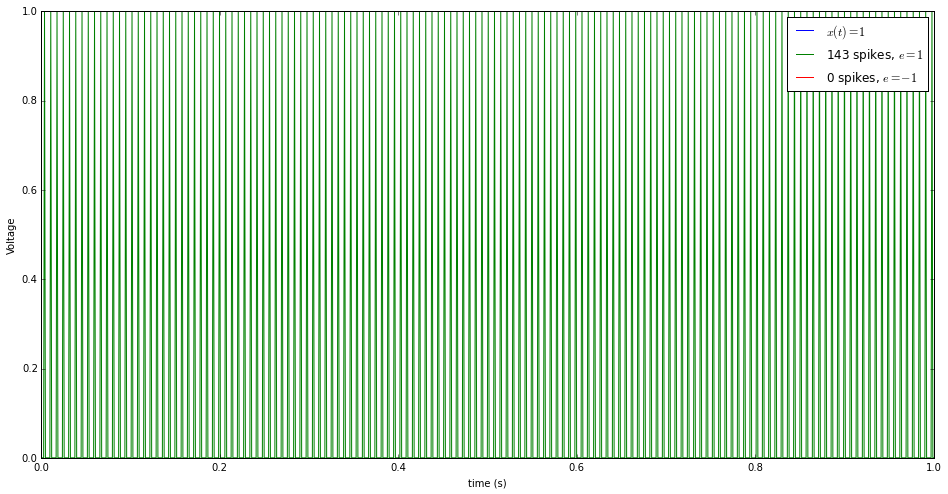

In [10]:
def three_b():

    x1=0
    x2=1
    a1=40
    a2=150
    e1=1
    e2=-1
    tau_ref=0.002
    tau_rc=0.02
    T=1
    dt=0.001
    rms=0.5
    limit=30
    seed=3

    x1_dot_e1=np.dot(x1,e1)
    x2_dot_e1=np.dot(x2,e1)
    x1_dot_e2=np.dot(x1,e2)
    x2_dot_e2=np.dot(-x2,e2)
    # print x1_dot_e1,x1_dot_e2,x2_dot_e1,x2_dot_e2
    n1=spikingLIFneuron(x1_dot_e1,x2_dot_e1,a1,a2,e1,tau_ref,tau_rc)
    n2=spikingLIFneuron(x1_dot_e2,x2_dot_e2,a1,a2,e2,tau_ref,tau_rc)
    t=np.arange(int(T/dt)+1)*dt
    stimulus2 = np.linspace(1,1,T/dt+1)
    n1.set_spikes(stimulus2,T,dt)
    n2.set_spikes(stimulus2,T,dt)
    spikes1=n1.get_spikes()
    spikes2=n2.get_spikes()

    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.plot(t,stimulus2, label='$x(t)=1$')
    ax.plot(t,spikes1, label='%s spikes, $e=1$' %np.count_nonzero(spikes1))
    ax.plot(t,-np.array(spikes2), label='%s spikes, $e=-1$' %np.count_nonzero(spikes2))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Voltage')
    ax.set_xlim(0,T)
    # ax.set_ylim(0,2)
    legend=ax.legend(loc='best') 
    plt.show()
    
three_b()

#### 3c Plot $x(t)$ and the spiking output for $x(t)={1 \over 2}sin(10\pi t)$ (a sine wave at 5Hz).

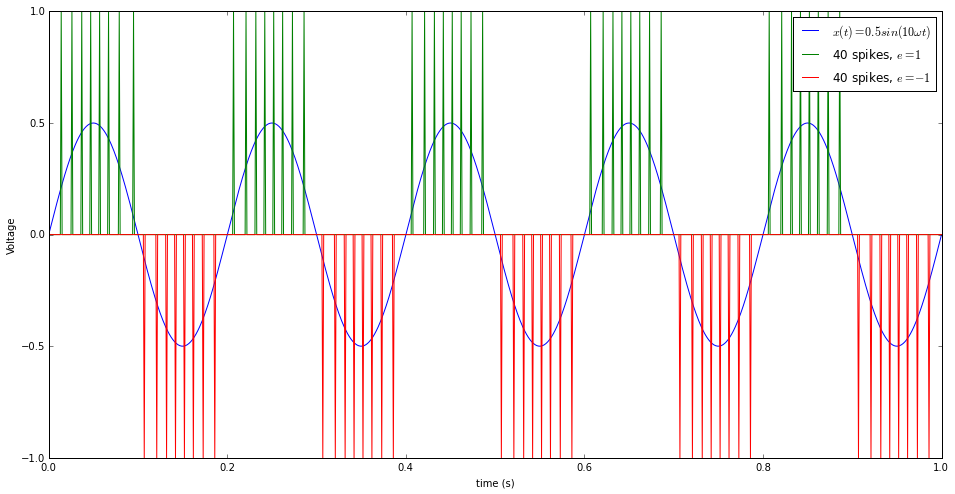

In [11]:
def three_c():

    x1=0
    x2=1
    a1=40
    a2=150
    e1=1
    e2=-1
    tau_ref=0.002
    tau_rc=0.02
    T=1
    dt=0.001
    rms=0.5
    limit=30
    seed=3

    x1_dot_e1=np.dot(x1,e1)
    x2_dot_e1=np.dot(x2,e1)
    x1_dot_e2=np.dot(x1,e2)
    x2_dot_e2=np.dot(-x2,e2)
    n1=spikingLIFneuron(x1_dot_e1,x2_dot_e1,a1,a2,e1,tau_ref,tau_rc)
    n2=spikingLIFneuron(x1_dot_e2,x2_dot_e2,a1,a2,e2,tau_ref,tau_rc)
    t=np.arange(int(T/dt)+1)*dt
    stimulus3 = 0.5*np.sin(10*np.pi*t)
    n1.set_spikes(stimulus3,T,dt)
    n2.set_spikes(stimulus3,T,dt)
    spikes1=n1.get_spikes()
    spikes2=n2.get_spikes()

    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.plot(t,stimulus3, label='$x(t)=0.5 sin(10 \omega t)$')
    ax.plot(t,spikes1, label='%s spikes, $e=1$' %np.count_nonzero(spikes1))
    ax.plot(t,-np.array(spikes2), label='%s spikes, $e=-1$' %np.count_nonzero(spikes2))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Voltage')
    ax.set_xlim(0,T)
    # ax.set_ylim(0,2)
    legend=ax.legend(loc='best') 
    plt.show()
    
three_c()

#### 3d  Plot $x(t)$ and the spiking output for a random signal generated with your function for question 1.1 with ``T``=2, ``dt``=0.001, ``rms``=0.5, and ``limit``=5.

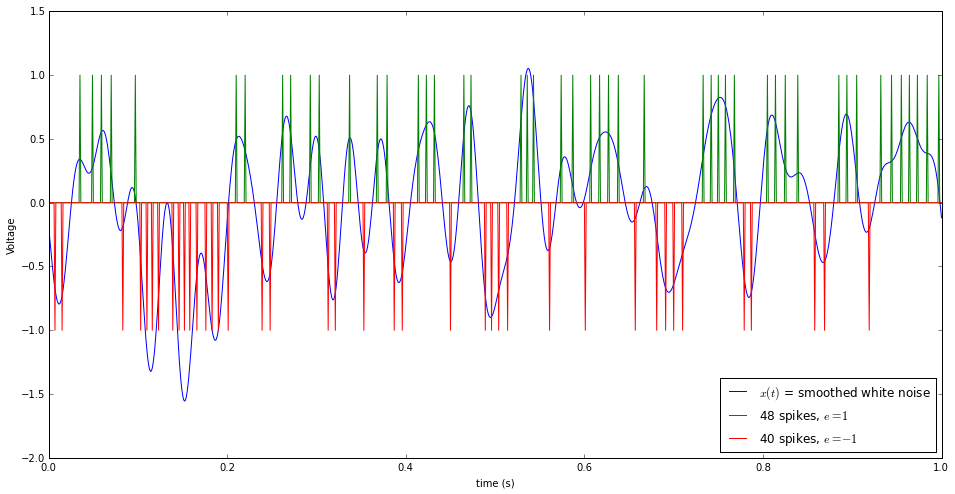

In [12]:
def three_d():

    x1=0
    x2=1
    a1=40
    a2=150
    e1=1
    e2=-1
    tau_ref=0.002
    tau_rc=0.02
    T=1
    dt=0.001
    rms=0.5
    limit=30
    seed=3

    x1_dot_e1=np.dot(x1,e1)
    x2_dot_e1=np.dot(x2,e1)
    x1_dot_e2=np.dot(x1,e2)
    x2_dot_e2=np.dot(-x2,e2)
    n1=spikingLIFneuron(x1_dot_e1,x2_dot_e1,a1,a2,e1,tau_ref,tau_rc)
    n2=spikingLIFneuron(x1_dot_e2,x2_dot_e2,a1,a2,e2,tau_ref,tau_rc)
    t=np.arange(int(T/dt)+1)*dt
    x_t, x_w = generate_signal(T,dt,rms,limit,seed,'uniform')
    stimulus4 = np.array(x_t)
    n1.set_spikes(stimulus4,T,dt)
    n2.set_spikes(stimulus4,T,dt)
    spikes1=n1.get_spikes()
    spikes2=n2.get_spikes()

    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.plot(t,stimulus4, label='$x(t)$ = smoothed white noise')
    ax.plot(t,spikes1, label='%s spikes, $e=1$' %np.count_nonzero(spikes1))
    ax.plot(t,-np.array(spikes2), label='%s spikes, $e=-1$' %np.count_nonzero(spikes2))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Voltage')
    ax.set_xlim(0,T)
    # ax.set_ylim(0,2)
    legend=ax.legend(loc='best') 
    plt.show()    
    
three_d()

## 4) Computing an Optimal Filter

Compute the optimal filter for decoding pairs of spikes.  Instead of implementing this yourself, here is an implementation in <a href="files/assignment2/optimal_filter.py">Python</a> and an implementation in <a href="files/assignment2/optimal_filter.m">Matlab</a>.  

#### 4a-d
<ol style="list-style:lower-alpha outside none;" start="1">
<li>Document the code and connect it with the code you wrote for part (3) so that it uses the signal used in 3.d.  Comments should be filled in where there are ``#`` signs (Python) or ``%`` signs (Matlab).  Replace the ``'???'`` labels in the code with the correct labels.</li>
<li>Plot the time and frequency plots for the optimal filter for the signal you generated in question 3.d.</li>
<li>Plot the $x(t)$ signal, the spikes, and the decoded $\hat{x}(t)$ value for the signal in question 3.d.</li>
<li>Plot the $|X(\omega)|$ power spectrum, $|R(\omega)|$ spike response spectrum, and the $|\hat{X}(\omega)|$ power spectrum for the signal in question 3.d. How do these relate to the optimal filter?</li>

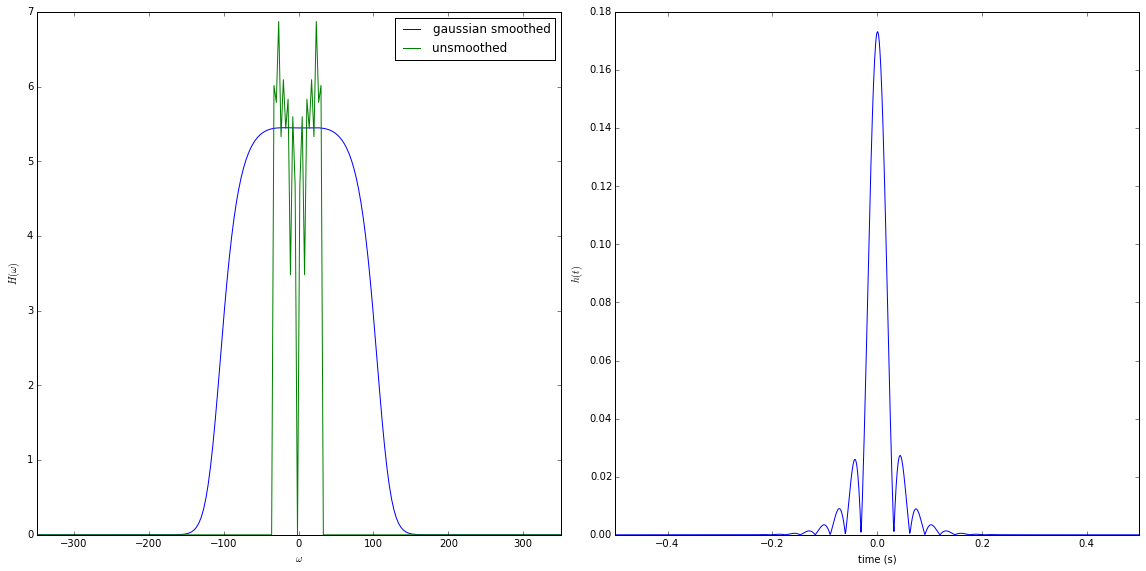

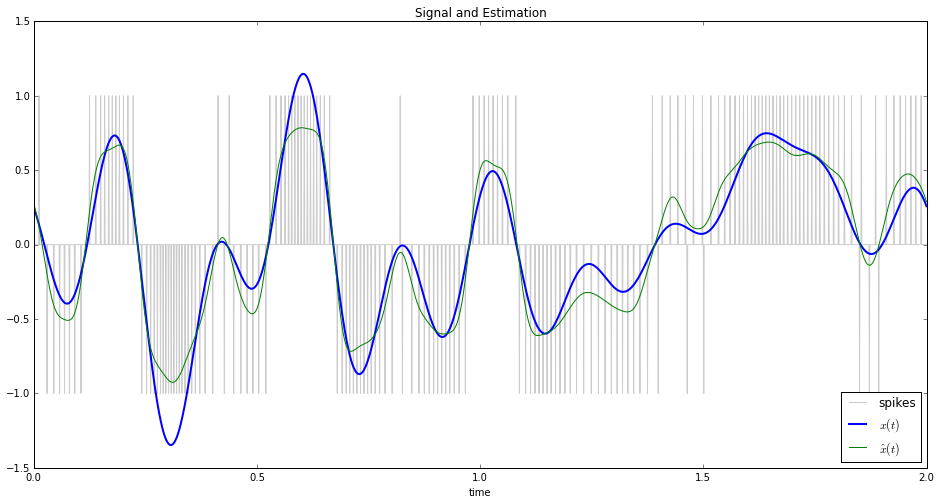

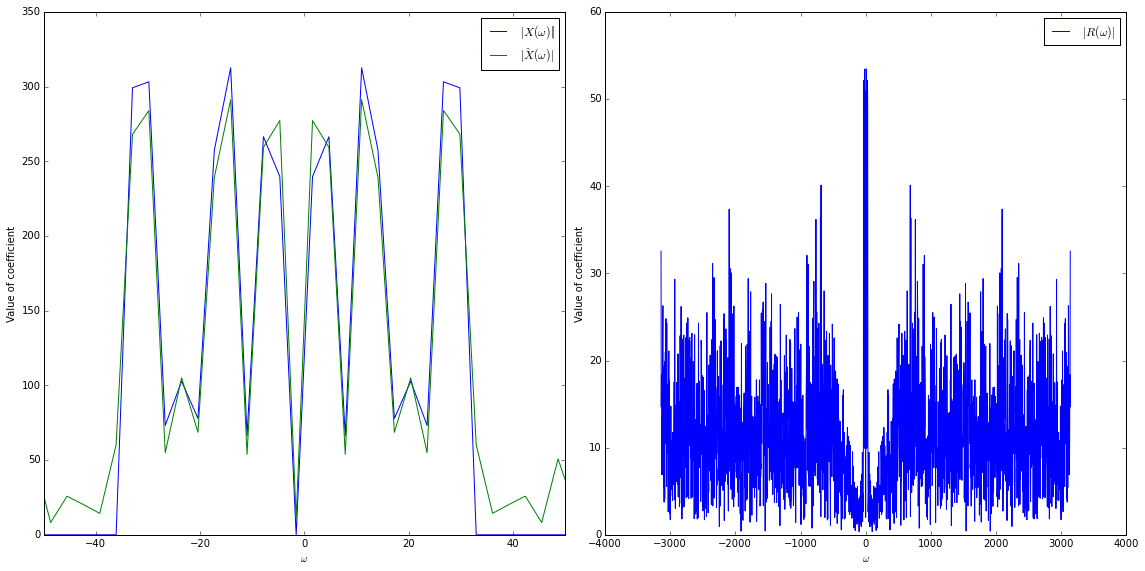

In [13]:
def four_a_thru_d():

    T = 2.0         # length of signal in seconds
    dt = 0.001      # time step size
    rms=0.5
    limit=5
    seed=3

    # Generate bandlimited white noise (use your own function from part 1.1)
    x_t, x_w = generate_signal(T,dt,rms,limit,seed,'uniform')

    Nt = len(x_t)           #length of the returned signal
    t = np.arange(Nt) * dt  #time values of the signal

    # Neuron parameters
    tau_ref = 0.002          # refractory period in seconds
    tau_rc = 0.02            # RC time constant in seconds
    x1 = 0.0                 # firing rate at x=x0 is a0
    a1 = 40.0
    x2 = 1.0                 # firing rate at x=x1 is a1
    a2 = 150.0

    #I actually calculate alpha and Jbias when I initialize the neurons, so I'm leaving out your code
    e1=1
    e2=-1
    x1_dot_e1=np.dot(x1,e1)
    x2_dot_e1=np.dot(x2,e1)
    x1_dot_e2=np.dot(x1,e2)
    x2_dot_e2=np.dot(-x2,e2)
    n1=spikingLIFneuron(x1_dot_e1,x2_dot_e1,a1,a2,e1,tau_ref,tau_rc) #create spiking neurons
    n2=spikingLIFneuron(x1_dot_e2,x2_dot_e2,a1,a2,e2,tau_ref,tau_rc)
    stimulus4 = np.array(x_t)             #set the stimulus of these neurons equal to the generated signal
    n1.set_spikes(stimulus4,T,dt)         #calculate the spikes corresponding to this signal 
    n2.set_spikes(stimulus4,T,dt)
    spikes1=n1.get_spikes()               #return the spikes
    spikes2=n2.get_spikes()
    spikes=np.array([spikes1,spikes2])    #put spikes in the given form

    freq = np.arange(Nt)/T - Nt/(2.0*T)   #frequencies in Hz of the signal, shifted from -f_max to +f_max
    omega = freq*2*np.pi                  #corresponding frequencies in radians

    # the response of the two neurons combined together:
    #nonzero values at each time step when one neuron spiked and the other did not
    r = spikes[0] - spikes[1]               
    # translate this response difference into the frequency domain,
    # this will turn convolution into multiplication and represents spike train power
    R = np.fft.fftshift(np.fft.fft(r))
    # X is frequency domain description of the white noise signal to be decoded (amplitudes A(w))
    X=np.fft.fftshift(x_w)                                 

    #width of the gaussian window filter, but with smaller sigma causing a larger window
    sigma_t = 0.025                          
    #Gaussian filter, expressing power as a function of the freqency omega
    #why multiply instead of divide by sigma^2? typo?
    #this is why small sigma creates large window rather than a small one like we expect for stddev
    W2 = np.exp(-omega**2*sigma_t**2)     
    #Normalize the filter form 0 to 1
    W2 = W2 / sum(W2)                        
                                
    # X(w)*R*(w) represents the correlated power between the signal and spike train amplitudes
    CP = X*R.conjugate()  
    # convolve the correlated power values with the gaussian (windowed filtering / averaging)
    WCP = np.convolve(CP, W2, 'same')  
    # Calculate |R(w_n:A)|^2, which idenetical to R * complex congugate R, and represents the spike train power
    RP = R*R.conjugate()
    # convolve the spike train power with the gaussian  (windowed filtering / averaging)
    WRP = np.convolve(RP, W2, 'same')   
    # Calculate the power spectrum |X(w)|^2, which idenetical to X * complex congugate X
    XP = X*X.conjugate()
    #convolve the R(w) values for the neuron pair response with the gaussian filter
    #not used in this code, but it could be used to calculate the error in frequency domain
    WXP = np.convolve(XP, W2, 'same')  
    #The optimal temporal filter in the frequency domain; equation 4.19 in NEF book
    H = WCP / WRP
    H_unsmoothed = CP / RP #for comparison

    # bring the optimal temporal filter into the time domain, making sure the frequencies line up properly
    h = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(H))).real  

    #The convolution of temporal filter and neuron pair response in the frequency domain,
    #returns the temporally filtered estimate for spiking neurons in frequency domain
    XHAT = H*R
    #bring the frequency domain state estimate into the time domain, ignoring imaginary parts
    xhat = np.fft.ifft(np.fft.ifftshift(XHAT)).real
         
    #4b
    fig=plt.figure(figsize=(16,8))
    # plt.title('Optimal Temporal Filter')
    ax=fig.add_subplot(121)
    #optimal temporal filter power, gaussian smoothed vs unsmoothed, real values in frequency space
    ax.plot(omega,H.real, label='gaussian smoothed') 
    ax.plot(omega,H_unsmoothed.real, label='unsmoothed')
    ax.set_xlabel('$\omega$')
    ax.set_ylabel('$H(\omega)$')
    ax.set_xlim(-350,350)
    legend=ax.legend(loc='best')
    ax=fig.add_subplot(122)
    # ax.plot(t-T/2, h)            #temporal filter power in the time domain
    ax.plot(t-T/2, np.abs(h))      #absolute value of temporal filter power in the time domain
    ax.set_xlabel('time (s)')
    ax.set_ylabel('$h(t)$')
    ax.set_xlim(-0.5,0.5)
    plt.tight_layout()
    plt.show()

    #4c
    fig=plt.figure(figsize=(16,8))
    plt.title('Signal and Estimation')
    ax=fig.add_subplot(111)
    plt.plot(t, r, color='k', label='spikes', alpha=0.2)  #neuron pair response function in time domain
    plt.plot(t, x_t, linewidth=2, label='$x(t)$')         #white noise signal in time domain
    plt.plot(t, xhat, label='$\hat{x}(t)$')               #estimated state in time domain, rms normalized
    # plt.title('Time Domain')
    legend=ax.legend(loc='best')
    ax.set_xlabel('time')
    plt.show()

    #4c
    fig=plt.figure(figsize=(16,8))
    # plt.title('Frequency Domain')
    # .real removes unnecessary warnings when plotting, but they have zero imaginary part so it makes no difference
    ax=fig.add_subplot(121)
    ax.plot(omega,np.sqrt(XP).real, label='$|X(\omega)$|')          #unsmoothed white noise signal in frequency space,
    ax.plot(omega,np.abs(XHAT).real, label='$|\hat{X}(\omega)|$')   #state estimate in frequency space
    ax.set_xlabel('$\omega$')
    ax.set_ylabel('Value of coefficient')
    ax.set_xlim(-50,50)
    legend=ax.legend(loc='best') 
    ax=fig.add_subplot(122)
    ax.plot(omega,np.sqrt(RP).real, label='$|R(\omega)|$')          #unsmoothed spike train pair response in w space
    ax.set_xlabel('$\omega$')
    ax.set_ylabel('Value of coefficient')
    legend=ax.legend(loc='best') 
    legend=ax.legend(loc='best') 
    legend=ax.legend(loc='best') 
    plt.tight_layout()
    plt.show()

four_a_thru_d()

The power spectrum for $X$ and $\hat{X}$ align fairly closely, giving a first indication that the state estimate is capturing the original signal. $\hat{X}$ does have spurious power above the cutoff, however, which ultimately gives the time-domain signal more high-frequency components than it should have.

$\hat{X}$ is the only spectrum which is related to the optimal filter, as it is calculated by convolving $h(t)$ with $r(t)$, or by multiplying $H(\omega)$ with $R(\omega)$ in the frequency domain and taking the inverse fourier transform:

$\hat{X(\omega)} = H(\omega) R(\omega)$. 

$X$ and $R$ are filtered with gaussian windowing in these plots, but this is an arbitrary filter that isn't related to $H$; they are, however, used to calculate $H(\omega)$:

$H(\omega)=\frac{\langle X(\omega) R^*(\omega) \rangle_A}{\langle |R(\omega)|^2\rangle_A}$,

where $\langle \rangle_A$ is the averaging over the gaussian window $A$. 

#### 4e Generate $h(t)$ time plots for the optimal filter for different ``limit`` values of 2Hz, 10Hz, and 30Hz.  Describe the effects on the time plot of the optimal filter as the ``limit`` increases.  Why does this happen?

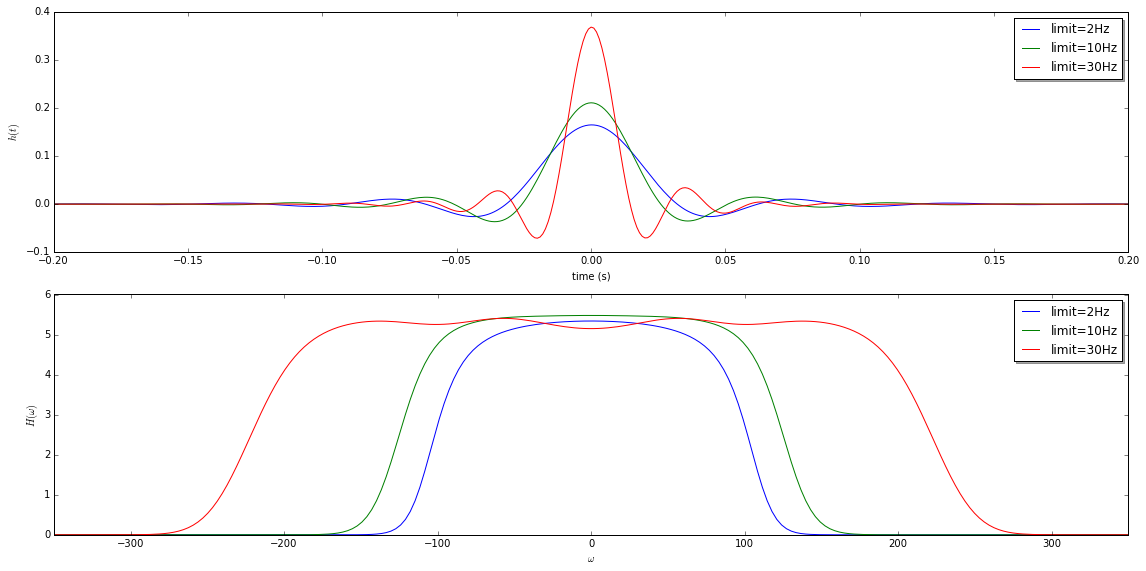

In [14]:
def four_e():

    T = 2.0         # length of signal in seconds
    dt = 0.001      # time step size
    rms=0.5
    limit=5
    seed=3          

    # Neuron creation and spike generation
    tau_ref = 0.002         
    tau_rc = 0.02            
    x1 = 0.0                 
    a1 = 40.0
    x2 = 1.0                 
    a2 = 150.0
    e1=1
    e2=-1
    x1_dot_e1=np.dot(x1,e1)
    x2_dot_e1=np.dot(x2,e1)
    x1_dot_e2=np.dot(x1,e2)
    x2_dot_e2=np.dot(-x2,e2)
    n1=spikingLIFneuron(x1_dot_e1,x2_dot_e1,a1,a2,e1,tau_ref,tau_rc)
    n2=spikingLIFneuron(x1_dot_e2,x2_dot_e2,a1,a2,e2,tau_ref,tau_rc)

    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(211)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('$h(t)$')
    ax.set_xlim(-0.2,0.2)
    ax2=fig.add_subplot(212)
    ax2.set_xlabel('$\omega$')
    ax2.set_ylabel('$H(\omega)$')
    ax2.set_xlim(-350,350)

    limits=[2,10,30]
    for i in range(len(limits)):  
        seed=i
        limit=limits[i]
        x_t, x_w = generate_signal(T,dt,rms,limit,seed,'uniform')
        Nt = len(x_t)                
        t = np.arange(Nt) * dt
        stimulus = np.array(x_t)   
        n1.set_spikes(stimulus,T,dt) 
        n2.set_spikes(stimulus,T,dt)
        spikes1=n1.get_spikes()     
        spikes2=n2.get_spikes()
        spikes=np.array([spikes1,spikes2])

        freq = np.arange(Nt)/T - Nt/(2.0*T)   
        omega = freq*2*np.pi                  

        r = spikes[0] - spikes[1]               
        R = np.fft.fftshift(np.fft.fft(r))
        X=np.fft.fftshift(x_w)                                 

        sigma_t = 0.025                          
        W2 = np.exp(-omega**2*sigma_t**2)     
        W2 = W2 / sum(W2)                        

        CP = X*R.conjugate()  
        WCP = np.convolve(CP, W2, 'same')  
        RP = R*R.conjugate()
        WRP = np.convolve(RP, W2, 'same')   
        XP = X*X.conjugate()
        WXP = np.convolve(XP, W2, 'same')  
        H = WCP / WRP
        H_unsmoothed = CP / RP

        h = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(H))).real
        ax.plot(t-T/2,h,label='limit=%sHz' %(limits[i]))
        ax2.plot(omega,H.real,label='limit=%sHz' %(limits[i]))

    legend=ax.legend(loc='best',shadow=True)
    legend=ax2.legend(loc='best',shadow=True)
    plt.tight_layout()
    plt.show()
    
four_e()

Increasing the frequency limit of the signal compresses the temporal filter in time, causing the decaying oscillations to occur nearer to  $t=0$ and with greater magnitude. Mathematically, increasing the limit increases the width of $H(\omega)$ due to a wider $X(w)$ in the numerator $X(w)*R(w)$ which translates to a greater number of high frequency components and more rapid oscillations in the time domain. These oscillations add coherently near $t=0$, causing a greater  magnitude in the temporal filter, but add destructively as $t$ increases, compressing the filter's power towards $t=0$. Intuitively, having a wider $H(\omega)$ means capturing more high-frequency components. In order to not smooth out these components in the time domain, the temporal filter $h(t)$ needs to oscillate on short time scales.

## 5) Using Post-Synaptic Currents as a Filter

Instead of using the optimal filter from the previous question, now we will use the post-synaptic current instead.  This is of the form $h(t)=t^n e^{-t/\tau}$ normalized to area 1.

#### 5a Plot the normalized $h(t)$ for $n$=0, 1, and 2 with $\tau$=0.007 seconds.  What two things do you expect increasing $n$ will do to $\hat{x}(t)$?

#### 5b Plot the normalized $h(t)$ for $\tau$=0.002, 0.005, 0.01, and 0.02 seconds with $n$=0.  What two things do you expect increasing $\tau$ will do to $\hat{x}(t)$?

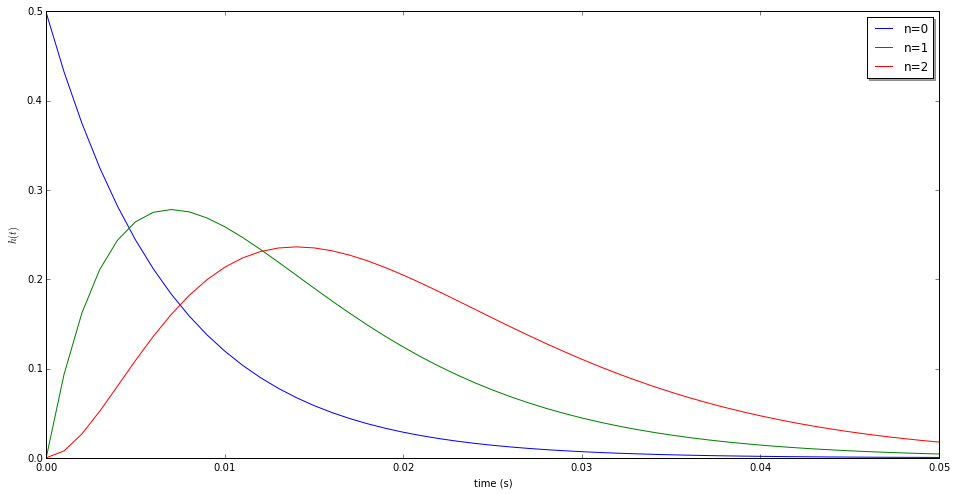

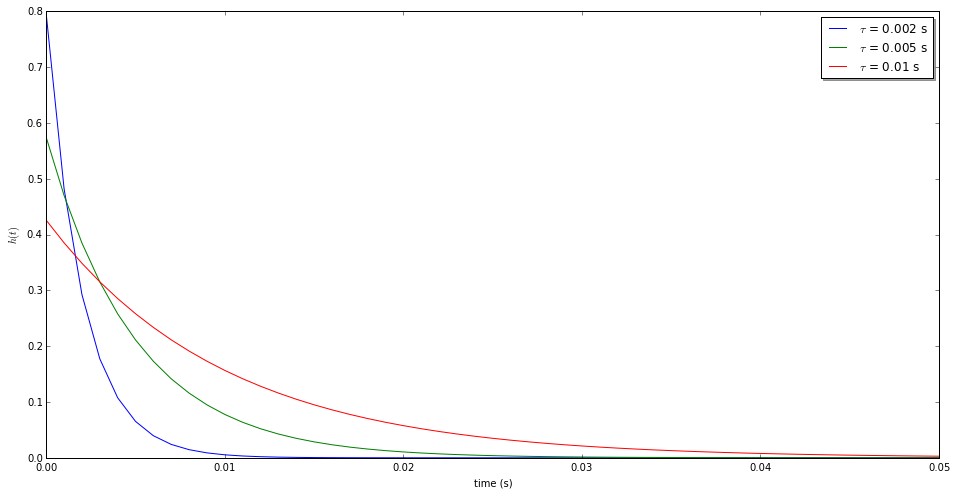

In [15]:
def five_a_thru_b():

    #5a
    T=1
    dt=0.001
    tau=0.007
    t=np.arange(T/dt)*dt
    n_list=[0,1,2]

    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('$h(t)$')
    for n in n_list:
        h=t**n*np.exp(-t/tau)
        h=h/np.linalg.norm(h)
        ax.plot(t,h,label='n=%s' %n)
    ax.set_xlim(0,0.05)
    legend=ax.legend(loc='best',shadow=True)
    plt.show()

    #5b
    T=1
    dt=0.001
    n=0
    t=np.arange(T/dt)*dt
    tau_list=[0.002,0.005,0.01]

    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('$h(t)$')
    for tau in tau_list:
        h=t**n*np.exp(-t/tau)
        h=h/np.linalg.norm(h)
        ax.plot(t,h,label='$\\tau$ = %s s' %tau)
    ax.set_xlim(0,0.05)
    legend=ax.legend(loc='best',shadow=True)
    plt.show()
    
five_a_thru_b()

I expect increasing $n$ to increase the amount of smoothing on $\hat{x}$, because $h$ extends farther in time with larger $n$, and so spreads the spikes farther out in time. Given the result of 5a, I also expect that a wider filter will decrease the high-frequency components of the. I expect increasing $n$ to cause greater lag in $\hat{x}$, because the peak of $h$ moves farther from zero with larger $n$.

I expect increasing $\tau$ to increase the amount of smoothing (in time) on $\hat{x}$, because $h$ extends farther in time with larger $\tau$. This will decrease the magnitude of the decoded signal (due to the lower power of $h$ at each $t$) as well as reduce high-frequency components, as above.

#### 5c Decode $\hat{x}(t)$ from the spikes generated in question 3.d using an $h(t)$ with $n$=0 and $\tau$=0.007.  Do this by generating the spikes, filtering them with $h(t)$, and using that as your activity matrix $A$ to compute your decoders.  Plot the time and frequency plots for this $h(t)$.  Plot the $x(t)$ signal, the spikes, and the decoded $\hat{x}(t)$ value.

#### 5d Use the same decoder and $h(t)$ as in part (c), but generate a new $x(t)$ with ``limit``=5Hz.  Plot the $x(t)$ signal, the spikes, and the decoded $\hat{x}(t)$ value.  How do these decodings compare?

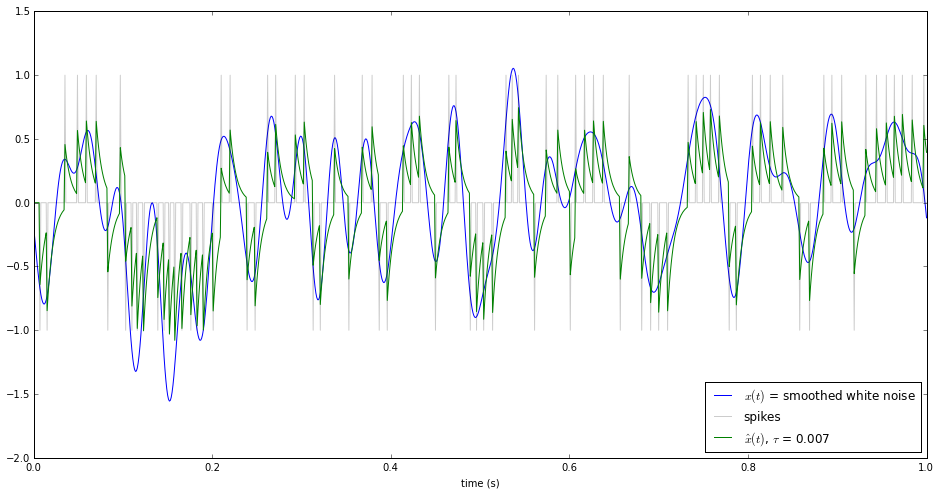

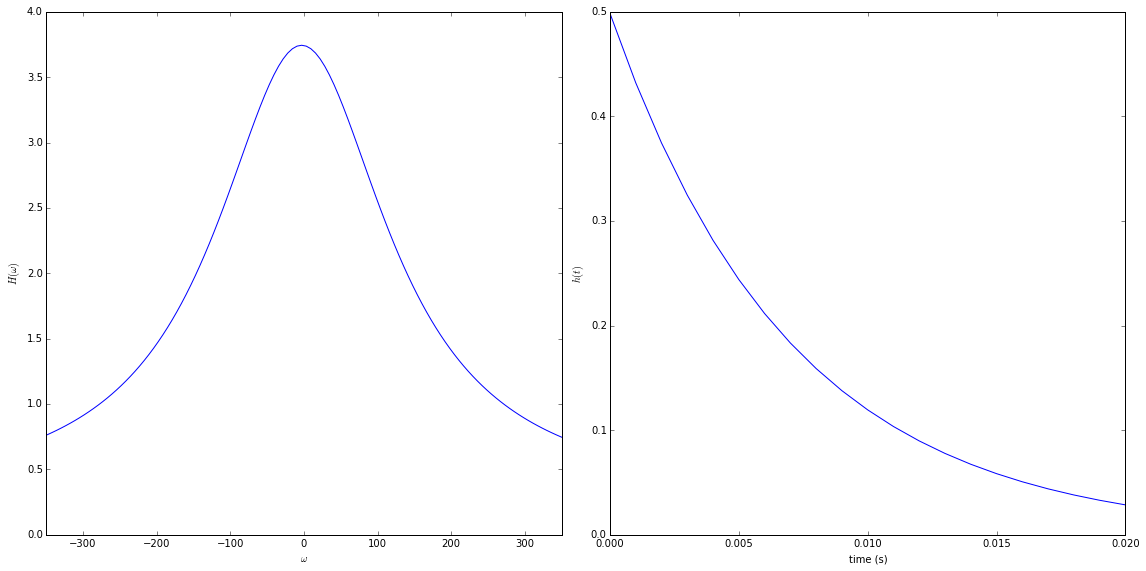

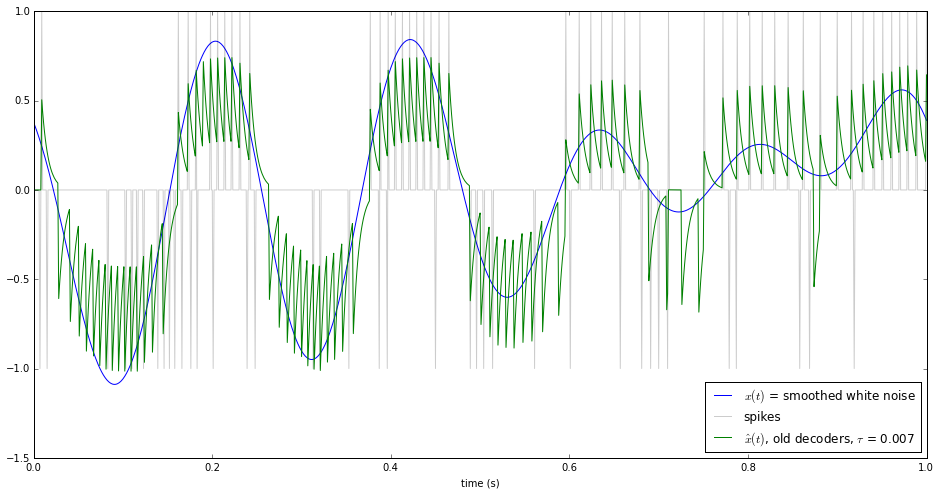

In [16]:
def five_c_thru_d():

    x1=0
    x2=1
    a1=40
    a2=150
    e1=1
    e2=-1
    tau_ref=0.002
    tau_rc=0.02
    T=1
    dt=0.001
    rms=0.5
    limit=30
    n=0
    tau_synapse=0.007
    seed=3

    #create neurons, generate signals, generate spikes
    x1_dot_e1=np.dot(x1,e1)
    x2_dot_e1=np.dot(x2,e1)
    x1_dot_e2=np.dot(x1,e2)
    x2_dot_e2=np.dot(-x2,e2)
    n1=spikingLIFneuron(x1_dot_e1,x2_dot_e1,a1,a2,e1,tau_ref,tau_rc)
    n2=spikingLIFneuron(x1_dot_e2,x2_dot_e2,a1,a2,e2,tau_ref,tau_rc)
    t=np.arange(int(T/dt)+1)*dt
    x_t, x_w = generate_signal(T,dt,rms,limit,seed,'uniform')
    stimulus = np.array(x_t)
    n1.set_spikes(stimulus,T,dt)
    n2.set_spikes(stimulus,T,dt)
    spikes1=n1.get_spikes()
    spikes2=n2.get_spikes()

    #set post-synaptic current temporal filter
    Nt = len(x_t)                
    freq = np.arange(Nt)/T - Nt/(2.0*T)   
    omega = freq*2*np.pi                  
    spikes=np.array([spikes1,spikes2])
    h=t**n*np.exp(-t/tau_synapse)
    h=h/np.linalg.norm(h)
    H=np.fft.fft(h)

    #calculate decoders and filtered state estimate
    d=get_decoders_smoothed(spikes,h,x_t)
    xhat=get_estimate_smoothed(spikes,h,d)

    #plot
    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.plot(t,x_t, label='$x(t)$ = smoothed white noise')
    plt.plot(t,(spikes[0]-spikes[1]), color='k', label='spikes', alpha=0.2)  #neuron pair response function in time domain
    ax.plot(t,xhat, label='$\hat{x}(t)$, $\\tau$ = %s' %tau_synapse)
    ax.set_xlabel('time (s)')
    legend=ax.legend(loc='best') 
    plt.show()

    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(121)
    ax.plot(omega,np.fft.fftshift(H).real)
    ax.set_xlabel('$\omega$')
    ax.set_ylabel('$H(\omega)$')
    ax.set_xlim(-350,350)
    ax=fig.add_subplot(122)
    ax.plot(t,h)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('$h(t)$')
    ax.set_xlim(0,0.02)
    plt.tight_layout()
    plt.show()

    #5d
    limit=5
    x_t2, x_w2 = generate_signal(T,dt,rms,limit,seed,'uniform')     #generate a new signal with limit=5hz
    stimulus2 = np.array(x_t2)
    n1.set_spikes(stimulus2,T,dt) #generate new spikes
    n2.set_spikes(stimulus2,T,dt)
    spikes3=n1.get_spikes()
    spikes4=n2.get_spikes()
    spikes2=np.array([spikes3,spikes4])
    xhat2=get_estimate_smoothed(spikes2,h,d) #estimate the new state with the old decoders

    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax.plot(t,x_t2, label='$x(t)$ = smoothed white noise')
    plt.plot(t,(spikes2[0]-spikes[1]), color='k', label='spikes', alpha=0.2)  #neuron pair response function in time domain
    ax.plot(t,xhat2, label='$\hat{x}(t)$, old decoders, $\\tau$ = %s' %tau_synapse)
    ax.set_xlabel('time (s)')
    legend=ax.legend(loc='best') 
    plt.show()

five_c_thru_d()

The estimate of the new signal works pretty well with the postsynaptic filter calculated using the old decoders. In both cases the small number of neurons makes it hard to capture the magnitude of the signal or transitions from positive to negative, but the old decoder estimate captures positive/negative values with only a small delay. The fidelity of a estimate calculated with the old decoders to a new signal indicates that postsynaptic filtering can be applied to estimate many signals without needing to fine-tune its parameters ($\tau$), which is advantageous for biological brains conserving mechanisms across diverse cognitive systems. It's error is also comparable to that of the optimal filter, without requiring an optimization procedure, indicating it may be a suitable (and biologically motivated) substitute for the optimal filter. 